In [1]:
import os, glob
import numpy as np
import numpy.random as rand
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection as slms, preprocessing as spre
from skimage import measure as meas, feature as feat
import cv2 as cv
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/ripe_classes/'

In [20]:
class MCPerceptron:
    def __init__(self,
                 n_samples,
                 n_features,
                 epochs,
                 activation='step',
                 loss='sse',
                 lr=0.01,
                 eps=1e-6,
                 weight_initializer='random_uniform',
                 use_bias=False,
                 bias_initializer='ones'):
        rand.seed(401)
        self.n_samples = n_samples
        self.n_features = n_features
        self.epochs = epochs
        self.activation = activation
        self.loss = loss
        self.lr = lr
        self.eps = eps
        self.weight_initializer = weight_initializer
        self.use_bias = use_bias
        self.bias_initializer = bias_initializer
        
        if self.weight_initializer == 'random_uniform':
            if use_bias:
                self.W = rand.random(self.n_features + 1)
            else:
                self.W = rand.random(self.n_features)
        elif self.weight_initializer == 'random_normal':
            if use_bias:
                self.W = rand.normal((0, 1, (self.n_features + 1)))
            else:
                self.W = rand.normal((0, 1, (self.n_features)))
        else:
            raise NotImplementedError
            
        if self.use_bias:
            if self.bias_initializer == 'ones':
                self.b = np.ones(self.n_samples)
            else:
                raise NotImplementedError

        if self.activation == 'step':
            self.g = lambda a: 1 if a >= 0 else -1
        elif self.activation == 'sigmoid':
            self.g = lambda a: 1/(1 + np.exp(-a))
        elif self.activation == 'softmax':
            self.g = lambda a: np.exp(a)/np.sum(np.exp(a))
        else:
            raise NotImplementedError
            
        if self.loss == 'sse':
            self.l = lambda y_true, y_pred: (y_true - y_pred)**2
        else:
            raise NotImplementedError

    def train(self, x, y):
        self.graph_res = []
        x = np.column_stack((self.b, x))
        for count in tnrange(self.epochs, desc='Epoch'):
            res = 0
            for i in range(self.n_samples):
                a = x[i].T.dot(self.W)
                z = self.g(a)
                dW = self.lr * (y[i] - z) * x[i]
                self.W += dW
                res += self.l(z, y[i])
            res /= self.n_samples
            self.graph_res.append(res)
            if res < self.eps:
                break
        self.last_epoch = count + 1
                 
    def predict(self, X, y=None, metrics=None):
        if self.use_bias:
            z = np.zeros(X.shape[0] + 1)
            X = np.column_stack((np.ones(len(X)), X))
        else:
            z = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            a = X[i].dot(self.W)
            z[i] = self.g(a)
        if metrics is not None and 'acc' in metrics and y is not None:
            acc = 0.
            for i in range(len(y)):
                if np.round(z[i]).astype(int) == y[i]:
                    acc += 1
            acc /= len(y)
            self.metrics = dict({'acc': acc})
        self.preds = z
        return z
                
    def get_weights(self):
        return self.W
    
    def get_biases(self):
        return self.x.T[0]

    def get_line_params(self):
        W = self.W
        A, B, C = W[1], W[2], -W[0]
        m = -A/B
        b = C/B
        return m, b
    
    def save_weights(self, filename):
        np.save(filename, self.W)
        
    def load_weights(self, filename):
        self.W = np.load(filename)


def getChannelMeans(x):
    return np.array([np.mean(x[:,:,i]) for i in range(3)])

def getFeatureVectors(X):
    for i,x in enumerate(X):
        if i == 0:
            features = np.zeros((len(X), 3))
        img = cv.imread(x)
        img = cv.cvtColor(img, cv.COLOR_BGR2Lab)/255
        features[i] = getChannelMeans(img)
    return features

In [21]:
unripes = []
ripes = []

files = glob.glob(traindir + 'Green/*.jpg')
for i,f in enumerate(files):
    if i == 0:
        unripes = np.zeros((len(files)), '<U256')
    unripes[i] = f
    
files = glob.glob(traindir + 'Overripen/*.jpg')
for i,f in enumerate(files):
    if i == 0:
        ripes = np.zeros((len(files)), '<U256')
    ripes[i] = f

In [22]:
unripes = unripes[:len(ripes)]
banana = np.concatenate((unripes, ripes))
classes = np.concatenate((np.tile(0, len(unripes)), np.tile(1, len(ripes))))
x_train, x_test, y_train, y_test = slms.train_test_split(banana, classes,
                                                         test_size=0.2, 
                                                         shuffle=True)

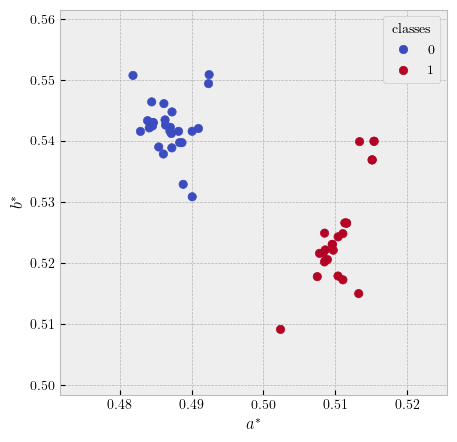

In [61]:
features = getFeatureVectors(x_train)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(features[:,1], features[:,2], 
                     marker='o', c=y_train, cmap='coolwarm')
legend = ax.legend(*scatter.legend_elements(), 
                   title='classes')
ax.add_artist(legend)
ax.set_xlabel('$a^*$')
ax.set_ylabel('$b^*$')
# plt.savefig('Lab_extract.png', dpi=300, bbox_inches='tight')
plt.show()

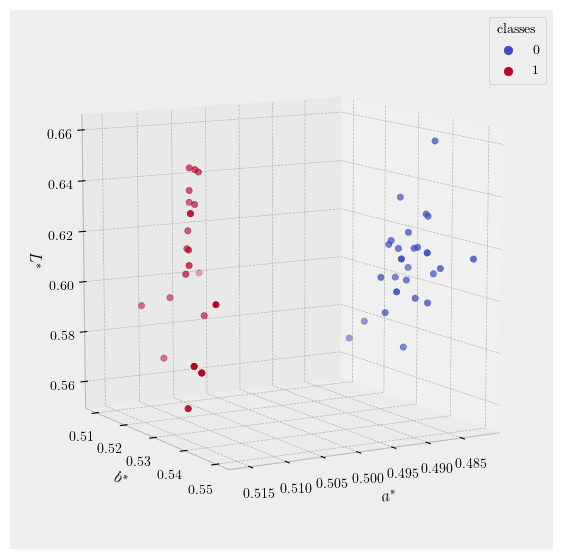

In [62]:
features = getFeatureVectors(x_train)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features[:,1], features[:,2], features[:,0], 
               'o', c=y_train, cmap='coolwarm')
legend = ax.legend(*scatter.legend_elements(), 
                   title='classes')
ax.add_artist(legend)
ax.set_xlabel('$a^*$')
ax.set_ylabel('$b^*$')
ax.set_zlabel('$L^*$')
ax.view_init(elev=10, azim=60)
# plt.savefig('Lab_extract.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
mcp = MCPerceptron(n_samples=len(x_train),
                   n_features=2,
                   epochs=int(1e6),
                   activation='sigmoid',
                   loss='sse',
                   lr=0.1,
                   eps=0.01,
                   use_bias=True)
mcp.train(features[:,1:], y_train)
mcp.save_weights('rgb.npy')

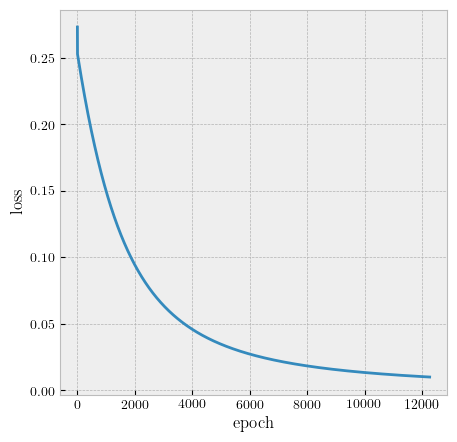

In [63]:
plt.plot(mcp.graph_res)
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.savefig('Lab_loss.png', dpi=300, bbox_inches='tight')
plt.show()

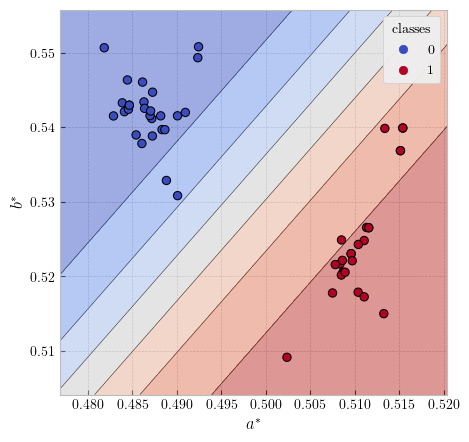

In [64]:
xmin, xmax = np.min(features[:,1])-5e-3, np.max(features[:,1])+5e-3
ymin, ymax = np.min(features[:,2])-5e-3, np.max(features[:,2])+5e-3
db_x = np.linspace(xmin, xmax, 100)
db_y = np.linspace(ymin, ymax, 100)
xx, yy = np.meshgrid(db_x, db_y)
Z = mcp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:-1].reshape(xx.shape)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.5)
ax.contour(xx, yy, Z, colors='k', linewidths=0.3)
ax.scatter(features[:,1], features[:,2], 
           marker='o', linewidths=0.75, edgecolors='k',
           c=y_train, cmap='coolwarm')

legend = ax.legend(*scatter.legend_elements(), 
                   title='classes')
ax.add_artist(legend)
ax.set_xlabel('$a^*$')
ax.set_ylabel('$b^*$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# plt.savefig('Lab_decision.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
features = getFeatureVectors(x_test)
mcp.predict(features[:,1:], y_test, metrics=['acc'])
mcp.metrics['acc']

1.0

In [66]:
files = glob.glob(traindir + 'Midripen/*.jpg')
for i,f in enumerate(files):
    if i == 0:
        midripes = np.zeros((len(files)), '<U256')
    midripes[i] = f

In [67]:
features = getFeatureVectors(midripes)
mcp.predict(features[:,1:])

array([0.42120632, 0.79990782, 0.20964118, 0.46693538, 0.68724639,
       0.35646361, 0.96225822, 0.8288363 , 0.77214657, 0.67789436,
       0.48214039, 0.81632637, 0.32320848, 0.97594261, 0.95424903,
       0.91272444, 0.94524378, 0.97792082, 0.32687543, 0.43477699,
       0.28644148, 0.36809726, 0.17504831, 0.33233565, 0.16453226,
       0.26038829, 0.26272023, 0.26272023, 0.3039407 , 0.2186399 ,
       0.19864718, 0.28291348, 0.19935015, 0.23550747, 0.35631767,
       0.33876742, 0.18209726, 0.31623516, 0.2366112 , 0.30463608,
       0.3276514 , 0.32036672, 0.22193718, 0.57259337, 0.44411491,
       0.30515899, 0.21084974, 0.33541582, 0.66773837, 0.277605  ,
       0.24788334, 0.36943143, 0.38078789, 0.15701747, 0.39680135,
       0.21324407, 0.30401209, 0.33678633, 0.41060905, 0.25975028,
       0.67666312, 0.52783354, 0.27681567, 0.49169995, 0.37551653,
       0.49176395, 0.48343416, 0.69253174, 0.55150831, 0.6216131 ,
       0.53633673, 0.69756858, 0.50806099, 0.72783301, 0.81544

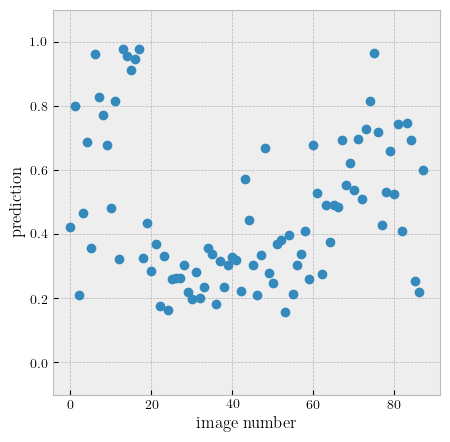

In [68]:
plt.plot(mcp.preds[:-1], 'o')
plt.ylim(-0.1, 1.1)
plt.xlabel('image number')
plt.ylabel('prediction')
# plt.savefig('Lab_preds.png', dpi=300, bbox_inches='tight')
plt.show()